In [1]:
import pandas as pd
from collections import Counter
import pymannkendall as mk
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('CDL_percent.csv')

In [3]:
df

,Year,huc12,Safflower,Open_Water,Other_Hay/Non_Alfalfa,Deciduous_Forest,Oats,Fallow/Idle_Cropland,Sod/Grass_Seed,Winter_Wheat,...,Buckwheat,Dbl_Crop_Barley/Corn,Radishes,Cherries,Camelina,Soybeans,Nonag/Undefined,Water,Developed,Clouds/No_Data
0,2005,170402080404,NaN,NaN,NaN,NaN,0.000851,11.435455,NaN,1.027731,...,NaN,NaN,NaN,NaN,NaN,NaN,0.146414,NaN,1.745545,NaN
1,2005,170402080502,NaN,NaN,NaN,NaN,NaN,9.418411,NaN,4.378855,...,NaN,NaN,NaN,NaN,NaN,NaN,0.078423,NaN,1.584811,NaN
2,2005,170402080501,NaN,NaN,NaN,NaN,0.002152,16.072317,NaN,0.920079,...,NaN,NaN,NaN,NaN,NaN,NaN,0.069261,NaN,0.740752,NaN
3,2005,170402080206,NaN,NaN,NaN,NaN,0.012949,5.411643,NaN,0.468678,...,NaN,NaN,NaN,NaN,NaN,NaN,0.136264,NaN,1.126078,0.023544
4,2005,170402080103,NaN,NaN,NaN,NaN,NaN,8.875553,NaN,0.235431,...,NaN,NaN,NaN,NaN,NaN,NaN,0.016684,NaN,0.181320,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,2023,170402080203,0.031864,0.002655,2.867771,2.105365,0.015932,1.592873,NaN,1.627820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
870,2023,170402080201,0.074855,0.003119,0.166374,2.760724,0.030290,4.263626,0.038987,0.547876,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871,2023,170402080306,2.037586,0.000401,2.538664,0.243081,0.111769,2.184821,0.009512,3.268955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
872,2023,170402080604,0.013496,NaN,0.022280,0.001311,NaN,0.137537,NaN,11.049987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
crop_cols = [col for col in df.columns if col not in ['Year', 'huc12']]

In [5]:
top5_counter = Counter()

for _, row in df.iterrows():
    top5 = row[crop_cols].sort_values(ascending=False)#.head(5)
    for col in top5.index:
        if row[col] > 0:
            top5_counter[col] +=1


In [6]:
top5_common = top5_counter.most_common()
for crop, count in top5_common:
    print(f"{crop}: appeared in top 5 {count} times")

Grass/Pasture: appeared in top 5 828 times
Alfalfa: appeared in top 5 826 times
Winter_Wheat: appeared in top 5 820 times
Spring_Wheat: appeared in top 5 807 times
Fallow/Idle_Cropland: appeared in top 5 804 times
Barley: appeared in top 5 803 times
Shrubland: appeared in top 5 782 times
Developed/Open_Space: appeared in top 5 782 times
Evergreen_Forest: appeared in top 5 777 times
Woody_Wetlands: appeared in top 5 770 times
Herbaceous_Wetlands: appeared in top 5 752 times
Deciduous_Forest: appeared in top 5 750 times
Developed/Low_Intensity: appeared in top 5 739 times
Other_Hay/Non_Alfalfa: appeared in top 5 727 times
Oats: appeared in top 5 687 times
Safflower: appeared in top 5 684 times
Potatoes: appeared in top 5 653 times
Open_Water: appeared in top 5 600 times
Corn: appeared in top 5 597 times
Developed/Med_Intensity: appeared in top 5 579 times
Mixed_Forest: appeared in top 5 560 times
Sod/Grass_Seed: appeared in top 5 513 times
Triticale: appeared in top 5 465 times
Barren: a

In [7]:
cdl_list = []
for crop, _ in top5_common:
    cdl_list.append(crop)

In [8]:
et_weights = {
    # Major irrigated crops
    'Alfalfa': 1.0,
    'Corn': 0.95,
    'Barley': 0.75,
    'Winter_Wheat': 0.65,
    'Spring_Wheat': 0.65,
    'Potatoes': 0.7,
    'Sugarbeets': 0.75,
    'Dry_Beans': 0.6,
    'Mustard': 0.55,
    'Soybeans': 0.7,
    'Safflower': 0.6,
    'Oats': 0.6,
    'Peas': 0.6,
    'Lentils': 0.6,
    'Other_Hay/Non_Alfalfa': 0.85,

    # 🌾 Fallow / low ET
    'Fallow/Idle_Cropland': 0.1,
    'Grass/Pasture': 0.7,
    'Sod/Grass_Seed': 0.7,

    # # Non-ag or natural covers (low or 0 weight)
    # 'Shrubland': 0.05,
    # 'Evergreen_Forest': 0.01,
    # 'Deciduous_Forest': 0.01,
    # 'Mixed_Forest': 0.01,
    # 'Woody_Wetlands': 0.05,
    # 'Herbaceous_Wetlands': 0.05,
    # 'Forest': 0.01,
    # 'Barren': 0.0,

    # # Developed & Other
    # 'Developed/Open_Space': 0.05,
    # 'Developed/Low_Intensity': 0.03,
    # 'Developed/Med_Intensity': 0.01,
    # 'Developed/High_Intensity': 0.01,
    # 'Developed': 0.01,

    # 'Open_Water': 0.0,
    # 'Water': 0.0,
    # 'Perennial_Ice/Snow': 0.0,
    # 'Clouds/No_Data': None,
    # 'Nonag/Undefined': None,

    # Rare crops (assign reasonable estimates or leave as needed)
    # 'Onions': 0.8,
    # 'Sweet_Corn': 0.9,
    # 'Mint': 0.75,
    # 'Tomatoes': 0.9,
    # 'Camelina': 0.6,
    # 'Chick_Peas': 0.6,
    # 'Clover/Wildflowers': 0.7,
    # 'Herbs': 0.7,
    # 'Cherries': 0.8,
    # 'Apples': 0.9,
    # 'Peaches': 0.9,
    # 'Radishes': 0.7,
    # 'Speltz': 0.6,
    # 'Buckwheat': 0.6,
    # 'Flaxseed': 0.6,
    # 'Other_Small_Grains': 0.65,
    # 'Other_Crops': 0.7,
    # 'Misc_Vegs_&_Fruits': 0.8,
    # 'Christmas_Trees': 0.01,
    # 'Dbl_Crop_Triticale/Corn': 0.9,
    # 'Dbl_Crop_WinWht/Corn': 0.9,
    # 'Dbl_Crop_Barley/Corn': 0.9,
    # 'Rye': 0.6,
    # 'Triticale': 0.6
}


In [ ]:
def compute_et_indices(row, weights_dict):
    unnormalized_sum = 0
    normalized_sum = 0
    valid_weights = 0

    for crop, pct in row.items():
        if crop in ['year', 'HUC12']: #to skip these columns
            continue
        weight = weights_dict.get(crop, None)
        if weight is not None and pct > 0:
            unnormalized_sum += pct * weight
            valid_weights += pct

    if valid_weights > 0:
        normalized_sum = unnormalized_sum / valid_weights
    else:
        normalized_sum = None  # No ag cover or all weights missing

    return pd.Series({
        'ET_index_unnormalized': unnormalized_sum,
        'ET_index_normalized': normalized_sum
    })


In [10]:
et_indices = df.apply(lambda row: compute_et_indices(row, et_weights), axis=1)
# df = pd.concat([df, et_indices], axis=1)


In [11]:
et_indices

,ET_index_unnormalized,ET_index_normalized
0,46.228890,0.615562
1,34.264227,0.620577
2,34.590122,0.573308
3,25.688137,0.631255
4,11.197133,0.476646
...,...,...
869,12.410682,0.795778
870,22.874697,0.700911
871,32.401465,0.845945
872,13.586635,0.672339


In [12]:
df_indices = pd.concat([df[['Year', 'huc12']], et_indices], axis=1)

In [13]:
df_indices

,Year,huc12,ET_index_unnormalized,ET_index_normalized
0,2005,170402080404,46.228890,0.615562
1,2005,170402080502,34.264227,0.620577
2,2005,170402080501,34.590122,0.573308
3,2005,170402080206,25.688137,0.631255
4,2005,170402080103,11.197133,0.476646
...,...,...,...,...
869,2023,170402080203,12.410682,0.795778
870,2023,170402080201,22.874697,0.700911
871,2023,170402080306,32.401465,0.845945
872,2023,170402080604,13.586635,0.672339


In [14]:
def compute_sen_slope(df, value_col, huc_col='huc12', year_col='Year'):
    """
    Computes Sen's slope and Mann-Kendall trend test for each HUC12.

    Parameters:
    - df: DataFrame with 'HUC12', 'year', and ET index columns
    - value_col: Name of the column to compute trend on (e.g., 'ET_index_unnormalized')

    Returns:
    - DataFrame with HUC12, sen_slope, trend direction, p-value
    """
    results = []

    for huc, group in df.groupby(huc_col):
        group_sorted = group.sort_values(year_col)
        series = group_sorted[value_col].values

        if len(series) >= 4 and not all(pd.isnull(series)):
            try:
                test_result = mk.original_test(series)
                results.append({
                    huc_col: huc,
                    f'{value_col}_slope': test_result.slope,
                    f'{value_col}_p': test_result.p,
                    f'{value_col}_trend': test_result.trend
                })
            except:
                results.append({
                    huc_col: huc,
                    f'{value_col}_slope': None,
                    f'{value_col}_p': None,
                    f'{value_col}_trend': None
                })
        else:
            results.append({
                huc_col: huc,
                f'{value_col}_slope': None,
                f'{value_col}_p': None,
                f'{value_col}_trend': None
            })

    return pd.DataFrame(results)


In [15]:
# For unnormalized index trend
cdl_trend_df = compute_sen_slope(df_indices, value_col='ET_index_unnormalized')

# Optional: For normalized index (only if you filtered to crop-only rows)
# et_trend_df = compute_sen_slope(df, value_col='ET_index_normalized')

# Merge with shapefile or original table if needed


In [16]:
cdl_trend_df

,huc12,ET_index_unnormalized_slope,ET_index_unnormalized_p,ET_index_unnormalized_trend
0,170402080101,-0.333936,0.068873,no trend
1,170402080102,-0.105893,0.262911,no trend
2,170402080103,-0.018554,0.207857,no trend
3,170402080104,-0.037245,0.528865,no trend
4,170402080105,-0.288797,0.107543,no trend
5,170402080106,-0.203972,0.107543,no trend
6,170402080107,0.187923,0.528865,no trend
7,170402080108,0.056790,0.833735,no trend
8,170402080201,-0.122673,0.068873,no trend
9,170402080202,-0.233265,0.363020,no trend


In [17]:
gdf = gpd.read_file('../portneuf_huc12/portneuf_huc12.shp')

In [18]:
# Make sure HUC12 in shapefile and trend_df match in type
gdf['huc12'] = gdf['huc12'].astype(str)
cdl_trend_df['huc12'] = cdl_trend_df['huc12'].astype(str)

In [19]:
merged_gdf_irr = gdf.merge(cdl_trend_df, left_on='huc12', right_on='huc12')

In [20]:
cdl_trend_df.columns

Index(['huc12', 'ET_index_unnormalized_slope', 'ET_index_unnormalized_p',
       'ET_index_unnormalized_trend'],
      dtype='object')

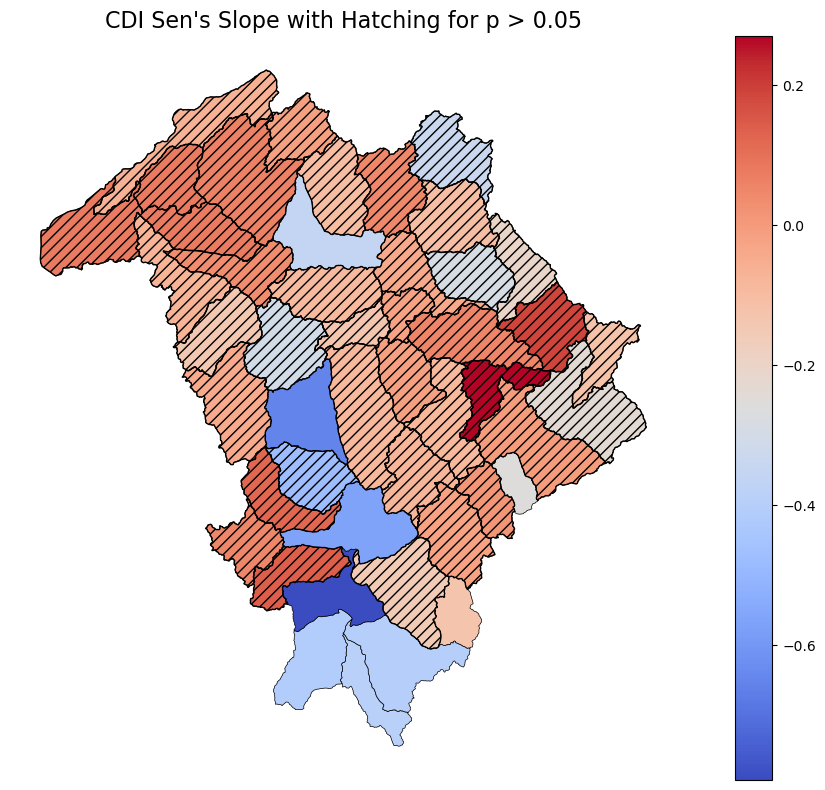

In [21]:
# Create masks for significance
sig = merged_gdf_irr['ET_index_unnormalized_p'] < 0.05
not_sig = ~sig

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot filled choropleth for all
merged_gdf_irr.plot(column='ET_index_unnormalized_slope', cmap='coolwarm', linewidth=0.5,
                edgecolor='black', legend=True, ax=ax)

# Hatch non-significant polygons
if not_sig.any():
    merged_gdf_irr[not_sig].plot(color='none', edgecolor='black', hatch='///', ax=ax)

ax.set_title("CDI Sen's Slope with Hatching for p > 0.05", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

In [22]:
df_indices

,Year,huc12,ET_index_unnormalized,ET_index_normalized
0,2005,170402080404,46.228890,0.615562
1,2005,170402080502,34.264227,0.620577
2,2005,170402080501,34.590122,0.573308
3,2005,170402080206,25.688137,0.631255
4,2005,170402080103,11.197133,0.476646
...,...,...,...,...
869,2023,170402080203,12.410682,0.795778
870,2023,170402080201,22.874697,0.700911
871,2023,170402080306,32.401465,0.845945
872,2023,170402080604,13.586635,0.672339


In [24]:
df_ind_mean = df_indices.groupby('huc12').agg(
    ET_index_un = ('ET_index_unnormalized', 'mean'),
    ET_index_n = ('ET_index_normalized', 'mean')

).reset_index()

In [25]:
df_ind_mean

,huc12,ET_index_un,ET_index_n
0,170402080101,8.179897,0.641152
1,170402080102,5.673167,0.766901
2,170402080103,1.072878,0.783050
3,170402080104,5.950552,0.897331
4,170402080105,21.609391,0.790194
5,170402080106,13.113327,0.818372
6,170402080107,24.916046,0.798721
7,170402080108,34.175613,0.786609
8,170402080201,23.982329,0.681968
9,170402080202,25.071296,0.638993


In [27]:
# Make sure HUC12 in shapefile and trend_df match in type
gdf['huc12'] = gdf['huc12'].astype(str)
df_ind_mean['huc12'] = df_ind_mean['huc12'].astype(str)
# Merge the long-term statistics with the HUC12 GeoDataFrame (huc12_gdf)
huc12_index = gdf.merge(df_ind_mean, on='huc12', how='left')

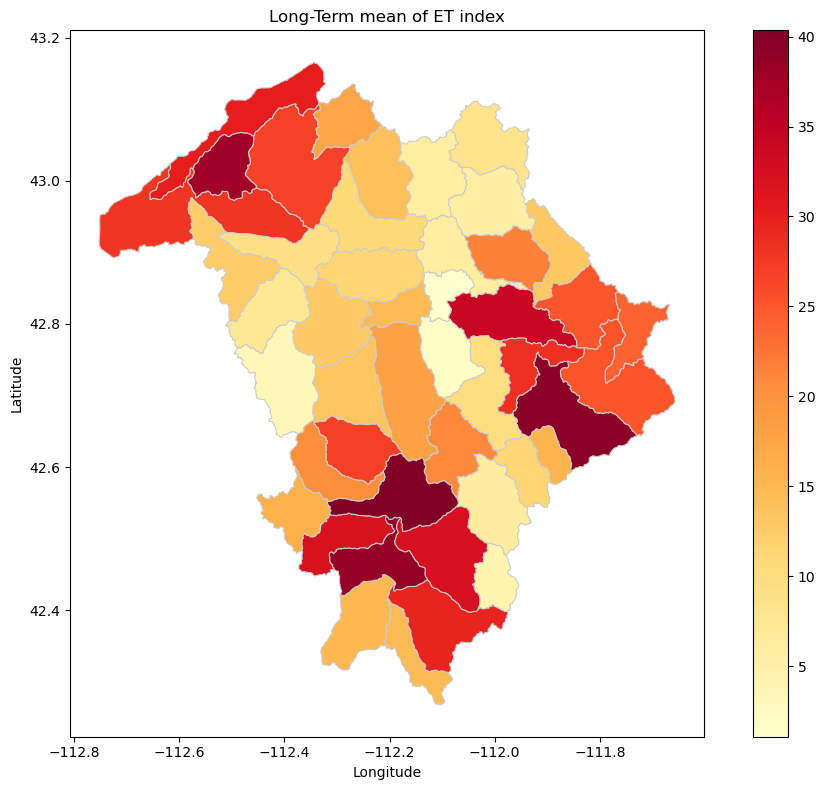

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
huc12_index.plot(column='ET_index_un', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Long-Term mean of ET index')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()
